# Genome Mining Notebook

## Configuration

Here are the parameters that you should edit for each run. The **runName** will be the name of the run, the **pattern** is the pattern to search lasso peptides against, the **cutoffRank** is the minimum required rank to run, the **genomeDir** is the directory where the FASTA and FNA files to be mined are stored, the **database** is where you would like the database to be written to, and **outputLogs** is where the output should be written to.

**models** is a list of models to generate motifs for and search with.

**memeDir** is the directory where the meme suite was installed on this computer, and **localMotifDir** is some empty or nonexistent directory that this program can use as scratch space.

In [210]:
import yaml
config = yaml.safe_load('''
# Setup parameters for a genome mining run

# positive controls
runName: "mltest"
genomeDir: "/home/nathan/Desktop/lassomining/genomes/positives/" # keep the trailing /
database: "/home/nathan/Desktop/lassomining/genomes/positives/output/matches.db" # no trailing /
cutoffRank: 0.4 # minimum rank to register as a hit

## Parameters for each run
pattern: 'M[A-Z]{15,45}T[A-Z][A-Z]{6,8}[DE][A-Z]{5,30}\*'
motifs:
  - "/home/nathan/Desktop/lassomining/models/memeb.xml"
  - "/home/nathan/Desktop/lassomining/models/memec.xml"
  
## Parameters you should not have to change
memeDir: "/home/nathan/meme"

''')

Below is a lot of the logic behind the mining, but just provides a series of functions to be used in the following code block

## Mining
Here are the commands for actually running the genome mining software. Output is printed below this block as it progresses, and this is the slowest running part of the program.

In [211]:
import traceback
import sys
import os
import time
import shutil
import json
from numpy import log2
from pathlib import Path
import cProfile
import numpy as np
from mining import mine

In [212]:
runName = config["runName"]
pattern = config["pattern"]
cutoffRank = config["cutoffRank"]
genomeDir = config["genomeDir"]
databaseDir = config["database"]
motifs = config["motifs"]
memeDir = config["memeDir"]
print("Beginning run " + runName)
print("cutting off hits below " + str(cutoffRank))
print("searching for pattern " + pattern)
print("Using these motifs:")
print(motifs)
print("Genomes being read from " + str(genomeDir))
print("writing output to " + databaseDir)

Beginning run mltest
cutting off hits below 0.4
searching for pattern M[A-Z]{15,45}T[A-Z][A-Z]{6,8}[DE][A-Z]{5,30}\*
Using these motifs:
['/home/nathan/Desktop/lassomining/models/memeb.xml', '/home/nathan/Desktop/lassomining/models/memec.xml']
Genomes being read from /home/nathan/Desktop/lassomining/genomes/positives/
writing output to /home/nathan/Desktop/lassomining/genomes/positives/output/matches.db


In [213]:
try:
    # start a timer
    t0 = time.time()
    
    # store meta data about the particular run
    runStatus = {
        "name": runName,
        "pattern": pattern,
        "input": [],
        "progress": 0.0,
        "peptides": 0,
        "cutoff": cutoffRank
    }
    
    ## create filepaths
    # create genome folder if not already there
    if not os.path.exists(genomeDir):
        print("could not find " + genomeDir + ", attempting to make it")
        os.makedirs(genomeDir)
    # create output database if not already there
    path = databaseDir.split("/")
    databaseFolder = "/".join(path[0:len(path) - 1])
    if not os.path.exists(databaseFolder):
        print("creating database directory " + databaseFolder)
        os.makedirs(databaseFolder)
    if not os.path.exists(databaseDir):
        print("Could not find " + databaseDir + ", attempting to create...")
        Path(databaseDir).touch()
       
    # mine(genomeDir, runName, pattern, cutoffRank, databaseDir, memeDir, motifs)
    cProfile.run('mine(genomeDir, runName, pattern, cutoffRank, databaseDir, memeDir, motifs)')
    print("finished all the runs for " + runName)
    
except Exception as error: 
    print("An error occured while mining")
    traceback.print_tb(sys.exc_info()[2])
    print(str(error))

translating fna files in directory folder /home/nathan/Desktop/lassomining/genomes/positives/
Read 1 objects from FASTA file /home/nathan/Desktop/lassomining/genomes/positives/lariatin.fasta

Read 1 objects from FASTA file /home/nathan/Desktop/lassomining/genomes/positives/sphingonodin.fastaRead 6 objects from FASTA file /home/nathan/Desktop/lassomining/genomes/positives/lariatin.faa
Read 1 objects from FASTA file /home/nathan/Desktop/lassomining/genomes/positives/caulonodin.fasta
Read 1 objects from FASTA file /home/nathan/Desktop/lassomining/genomes/positives/microcin.fastaRead 1 objects from FASTA file /home/nathan/Desktop/lassomining/genomes/positives/caulosegnin.fasta

Read 1 objects from FASTA file /home/nathan/Desktop/lassomining/genomes/positives/burhizin.fasta
Read 1 objects from FASTA file /home/nathan/Desktop/lassomining/genomes/positives/sro15.fastaRead 6 objects from FASTA file /home/nathan/Desktop/lassomining/genomes/positives/microcin.faa

Read 1 objects from FASTA file 

KeyboardInterrupt: 

Read 6 objects from FASTA file /home/nathan/Desktop/lassomining/genomes/positives/astexin1.faa
Read 6 objects from FASTA file /home/nathan/Desktop/lassomining/genomes/positives/burhizin.faa
Read 36 objects from FASTA file /home/nathan/Desktop/lassomining/genomes/positives/lariatin.faa
An error occured with running MAST
Command '['/home/nathan/meme/bin/mast', '-hit_list', '/home/nathan/Desktop/lassomining/models/memec.xml', '/home/nathan/Desktop/lassomining/genomes/positives/burhizin.fa.tempseq.txt']' died with <Signals.SIGABRT: 6>.


## Lasso Viewer

A rudimentary method of looking at lassos within this notebook.

In [214]:
import sqlite3
import pandas as pd
from demjson import decode
import matplotlib.pyplot as plt

In [215]:
# regular expression function for regular expression search
def regexp(expr, item):
    reg = re.compile(expr)
    return reg.search(item) is not None

conn = sqlite3.connect(config["database"])
conn.create_function("REGEXP", 2, regexp)

In [216]:
c = conn.cursor()
selection_string = "SELECT DISTINCT genome FROM lassopeptides WHERE runname is '" + config["runName"] + "'"
distinct_genomes = []
for row in c.execute(selection_string):
    distinct_genomes.append(row[0])

c.close()
print(distinct_genomes)

['Escherichia coli', 'Sphingobium japonicum', 'Caulobacter sp.', 'Asticcacaulis excentricus', 'Burkholderia rhizoxinica', 'Rhodococcus jostii', 'Streptomyces filamentosus', 'Burkholderia thailandensis', 'Streptomyces sviceus', 'Rubrivivax gelatinosus', 'Caulobacter segnis']


In [217]:
import json
genome = 'Caulobacter segnis'
c = conn.cursor()
selection_string = f'SELECT DISTINCT sequence, start, end, overallLength, rank, orf, closestOrfs, secondaryRank FROM lassopeptides WHERE runname is "{config["runName"]}" AND genome is "{genome}"'
lasso_peptides = []
for row in c.execute(selection_string):
    lasso_peptides.append({
        "sequence": row[0],
        "start": row[1],
        "end": row[2],
        "overallLength": row[3],
        "rank": row[4],
        "orf": row[5],
        "closestOrfs": decode(json.loads(row[6])),
        "secondaryRank": row[7]
    })
def sortFunct(lasso):
    return lasso["secondaryRank"]
lasso_peptides.sort(key=sortFunct, reverse=True)

c.close()

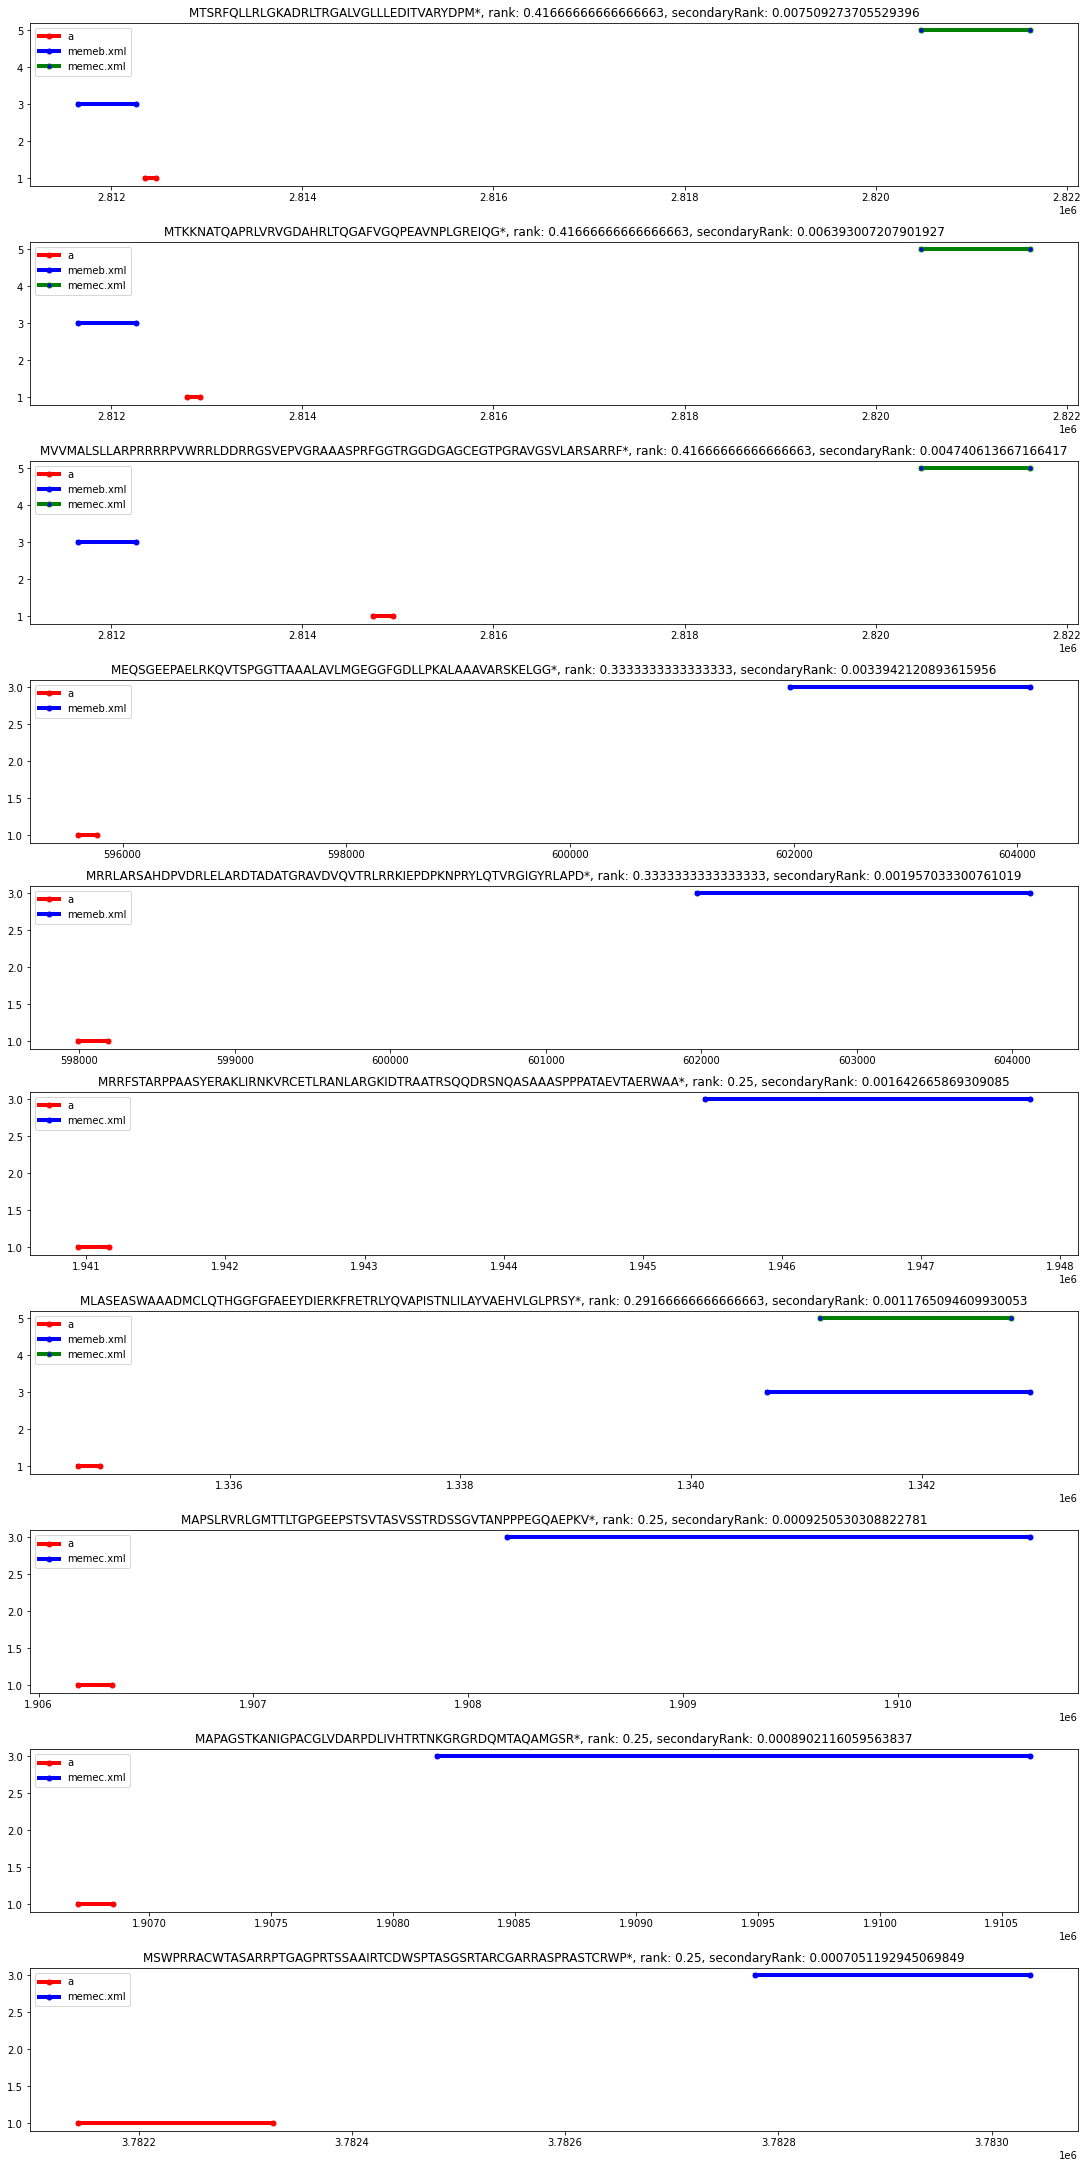

In [218]:
num_to_show = 10
fig, axs = plt.subplots(num_to_show, 1, figsize=(15,30), constrained_layout=True)

color_arr = ['blue', 'green', 'yellow', 'purple', 'brown', 'cyan']
count = 0
for lasso in lasso_peptides[0:num_to_show]:
    a = {'x': [lasso["start"], lasso["end"]], 'y': [1, 1]}
    axs[count].plot( a['x'], a['y'], label='a', marker='o', markerfacecolor='red', markersize=5, color='red', linewidth=4)
    inner_count = 0
    for closeOrf in lasso['closestOrfs']:
        axs[count].plot( [closeOrf['start'], closeOrf['end']], [3 + (2 * inner_count), 3 + (2 * inner_count)], label=closeOrf["motifType"],  marker='o', markerfacecolor='blue', markersize=5, color=color_arr[inner_count % len(color_arr)], linewidth=4)
        inner_count += 1
    axs[count].set_title(f'{lasso["sequence"]}, rank: {lasso["rank"]}, secondaryRank: {lasso["secondaryRank"]}')
    _ = axs[count].legend()
    count += 1

plt.show()

In [79]:
ind = 0
for lasso in lasso_peptides:
    ind += 1
    if("GQPEAVNP" in lasso["sequence"]):
        print("found the real!")
        print(lasso["sequence"])
        print(f'index: {ind}, rank: {lasso["rank"]}, secondaryRank: {lasso["secondaryRank"]}')

found the real!
MTKKNATQAPRLVRVGDAHRLTQGAFVGQPEAVNPLGREIQG*
index: 1178, rank: 0.41666666666666663, secondaryRank: 3.923265317162835e-15


## Graphical Genome-wide representations
Plots the rank distribution of the peptides found - a straight line indicates non discrimination occured while ranking, whereas a steep cutoff indicates that the "good" hits were strongly separated from noise.

In [ ]:
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
# regular expression function for regular expression search
def regexp(expr, item):
    reg = re.compile(expr)
    return reg.search(item) is not None

conn = sqlite3.connect(config["database"])
conn.create_function("REGEXP", 2, regexp)

In [ ]:
c = conn.cursor()
selection_string = "SELECT DISTINCT genome FROM lassopeptides WHERE runname is '" + config["runName"] + "'"
distinct_genomes = []
for row in c.execute(selection_string):
    distinct_genomes.append(row[0])

c.close()
print(distinct_genomes)

In [ ]:
genome_ranks = {}
c = conn.cursor()
for genome in distinct_genomes:
    selection_string = f'SELECT rank FROM lassopeptides WHERE runname is "{config["runName"]}" AND genome is "{genome}"'
    ranks = []
    for row in c.execute(selection_string):
        ranks.append(row[0])
    ranks.sort(reverse=True)
    genome_ranks[genome] = ranks
c.close()

In [ ]:
'''
# Multiple genomes at once
fig, axs = plt.subplots(len(distinct_genomes), 1, figsize=(10,15))
ind = 0
for genome in genome_ranks.keys():
    y = genome_ranks[genome]
    x = range(0, len(y))
    axs[ind].plot(x, y)
    axs[ind].set_title(genome)
    axs[ind].set(xlabel="number of peptides with this rank or higher", ylabel="rank")
    ind += 1
'''
genome = distinct_genomes[0]
y = genome_ranks[genome]
x = range(0, len(y))
plt.plot(x, y)
plt.title(genome)
plt.xlabel("number of peptides with this rank or higher")
plt.ylabel("rank")

In [ ]:
c = conn.cursor()
selection_string = "SELECT DISTINCT genome FROM lassopeptides WHERE runname is '" + config["runName"] + "'"
distinct_genomes = []
for row in c.execute(selection_string):
    distinct_genomes.append(row[0])

c.close()
print(distinct_genomes)

In [ ]:
genome_ranks = {}
c = conn.cursor()
for genome in distinct_genomes:
    selection_string = f'SELECT secondaryRank FROM lassopeptides WHERE runname is "{config["runName"]}" AND genome is "{genome}"'
    ranks = []
    for row in c.execute(selection_string):
        ranks.append(row[0])
    ranks.sort(reverse=True)
    genome_ranks[genome] = ranks
c.close()

In [ ]:
'''
# Multiple genomes at once
fig, axs = plt.subplots(len(distinct_genomes), 1, figsize=(10,15))
ind = 0
for genome in genome_ranks.keys():
    y = genome_ranks[genome]
    x = range(0, len(y))
    axs[ind].plot(x, y)
    axs[ind].set_title(genome)
    axs[ind].set(xlabel="number of peptides with this rank or higher", ylabel="rank")
    ind += 1
'''
genome = distinct_genomes[0]
y = genome_ranks[genome]
x = range(0, len(y))
plt.plot(x, y)
plt.title(genome)
plt.xlabel("number of peptides with this rank or higher")
plt.ylabel("secondary rank")

## Export
Export data to CSVs and Firebase

In [ ]:
import os

In [ ]:
from mining import export_to_csv
if(not os.path.isdir('output/csvs')):
    os.mkdir('output/csvs')
export_to_csv(config["runName"], config["database"], os.path.join('output', 'csvs'))

In [ ]:
from mining import export_to_firebase, clear_firebase

In [ ]:
clear_firebase('/home/nalam/lassomining/output/lasso-peptides-51ce2e6250b9.json')

In [ ]:
export_to_firebase(db_dir=config["database"], run_name=config["runName"], cred_file=False)

## Positive Control Verification

In [8]:
real_lasso_text = '''
astexin-1	MHTPIISETVQPKTAGLIVLGKASAETRGLSQGVEPDIGQTYFEESRINQD			Asticcacaulis excentricus CB 48 chromosome 1, complete sequence
burhizin	MNKQQQESGLLLAEESLMELCASSETLGGAGQYKEVEAGRWSDRIDSDDE			Burkholderia rhizoxinica HKI 454, complete genome
capistruin	MVRLLAKLLRSTIHGSNGVSLDAVSSTHGTPGFQTPDARVISRFGFN			Burkholderia thailandensis E444 chromosome 1, complete sequence
caulonodin I	MERIEDHIDDELIDLGAASVETQGDVLNAPEPGIGREPTGLSRD			Caulobacter sp. K31 plasmid pCAUL01, complete sequence
caulonodin II	MQRIIDETTDGLIELGAASVQTQGDVLFAPEPGVGRPPMGLSED			Caulobacter sp. K31 plasmid pCAUL01, complete sequence
caulosegnin I	MTKKNATQAPRLVRVGDAHRLTQGAFVGQPEAVNPLGREIQG			Caulobacter segnis ATCC 21756, complete genome
caulosegnin II	MTKTHRLIRLGDAQRLTQGTLTPGLPEDFLPGHYMPG			Caulobacter segnis ATCC 21756, complete genome
caulosegnin III	MTSRFQLLRLGKADRLTRGALVGLLLEDITVARYDPM			Caulobacter segnis ATCC 21756, complete genome
lariatin	MTSQPSKKTYNAPSLVQRGKFARTTAGSQLVYREWVGHSNVIKPGP			Rhodococcus jostii lariatin biosynthetic gene cluster (larA, larB, larC, larD, larE), complete cds
rubrivinodin	MDEELELEIVDLGDAKELTQGAPSLINSEDNPAFPQRV			Rubrivivax gelatinosus IL144 DNA, complete genome
sphingonodin II	MDRHDNSEVDEIIDLGTASAVTQGMGSGSTDQNGQPKNLIGGISDD			Sphingobium japonicum UT26S plasmid pCHQ1 DNA, complete genome
SRO15-2005	MKQQKQQKKAYVKPSMFQQGDFSKKTAGYFVGSYKEYWSRRII			Streptomyces roseosporus NRRL 15998 supercont3.1 genomic scaffold, whole genome shotgun sequence
SSV-2083 	MLISTTNGQGTPMTSTDELYEAPELIEIGDYAELTRCVWGGDCTDFLGCGTAWICV			Streptomyces sviceus ATCC 29083 chromosome, whole genome shotgun sequence
microcin J25	MIKHFHFNKLSSGKKNNVPSPAKGVIQIKKSASQLTKGGAGHVPEYFVGIGTPISFYG			Escherichia coli plasmid pTUC100 microcin J25 precursor (mcjA), McjB (mcjB), McjC (mcjC), and McjD (mcjD) genes, complete cds
'''

In [20]:

parse = list(filter(None, real_lasso_text.replace('\n', '	').split('	')))
parse

['astexin-1',
 'MHTPIISETVQPKTAGLIVLGKASAETRGLSQGVEPDIGQTYFEESRINQD',
 'Asticcacaulis excentricus CB 48 chromosome 1, complete sequence',
 'burhizin',
 'MNKQQQESGLLLAEESLMELCASSETLGGAGQYKEVEAGRWSDRIDSDDE',
 'Burkholderia rhizoxinica HKI 454, complete genome',
 'capistruin',
 'MVRLLAKLLRSTIHGSNGVSLDAVSSTHGTPGFQTPDARVISRFGFN',
 'Burkholderia thailandensis E444 chromosome 1, complete sequence',
 'caulonodin I',
 'MERIEDHIDDELIDLGAASVETQGDVLNAPEPGIGREPTGLSRD',
 'Caulobacter sp. K31 plasmid pCAUL01, complete sequence',
 'caulonodin II',
 'MQRIIDETTDGLIELGAASVQTQGDVLFAPEPGVGRPPMGLSED',
 'Caulobacter sp. K31 plasmid pCAUL01, complete sequence',
 'caulosegnin I',
 'MTKKNATQAPRLVRVGDAHRLTQGAFVGQPEAVNPLGREIQG',
 'Caulobacter segnis ATCC 21756, complete genome',
 'caulosegnin II',
 'MTKTHRLIRLGDAQRLTQGTLTPGLPEDFLPGHYMPG',
 'Caulobacter segnis ATCC 21756, complete genome',
 'caulosegnin III',
 'MTSRFQLLRLGKADRLTRGALVGLLLEDITVARYDPM',
 'Caulobacter segnis ATCC 21756, complete genome',
 'lariatin',


In [124]:
real_lassos = []
for e in range(0, len(parse) - 2, 3):
    real_lassos.append({
        "name": parse[e],
        "sequence": parse[e + 1] + '*',
        "description": parse[e + 2]
    })

In [125]:
import sqlite3
import pandas as pd
# regular expression function for regular expression search
def regexp(expr, item):
    reg = re.compile(expr)
    return reg.search(item) is not None

conn = sqlite3.connect(config["database"])
conn.create_function("REGEXP", 2, regexp)
c = conn.cursor()
selection_string = "SELECT DISTINCT sequence, rank, secondaryRank, genome FROM lassopeptides WHERE runname is '" + config["runName"] + "'"
matches = []
for row in c.execute(selection_string):
    matches.append({
        "sequence": row[0],
        "rank": row[1],
        "secondaryRank": row[2],
        "genome": row[3]
    })
c.close()

In [126]:
for real_lasso in real_lassos:
    found_lasso = False
    for match in matches:
        if(match["sequence"][-10:] == real_lasso["sequence"][-10:]):
#             print(f'Found {real_lasso["name"]} in {match["genome"]}')
#             print(match)
            real_lasso["secondaryRank"] = match["secondaryRank"]
            real_lasso["primaryRank"] = match["rank"]
            found_lasso = True
    
    if not found_lasso:
        print(f'Could not find {real_lasso["name"]}')
        print(real_lasso)
    print('\n')













Could not find caulosegnin II
{'name': 'caulosegnin II', 'sequence': 'MTKTHRLIRLGDAQRLTQGTLTPGLPEDFLPGHYMPG*', 'description': 'Caulobacter segnis ATCC 21756, complete genome'}




Could not find lariatin
{'name': 'lariatin', 'sequence': 'MTSQPSKKTYNAPSLVQRGKFARTTAGSQLVYREWVGHSNVIKPGP*', 'description': 'Rhodococcus jostii lariatin biosynthetic gene cluster (larA, larB, larC, larD, larE), complete cds'}














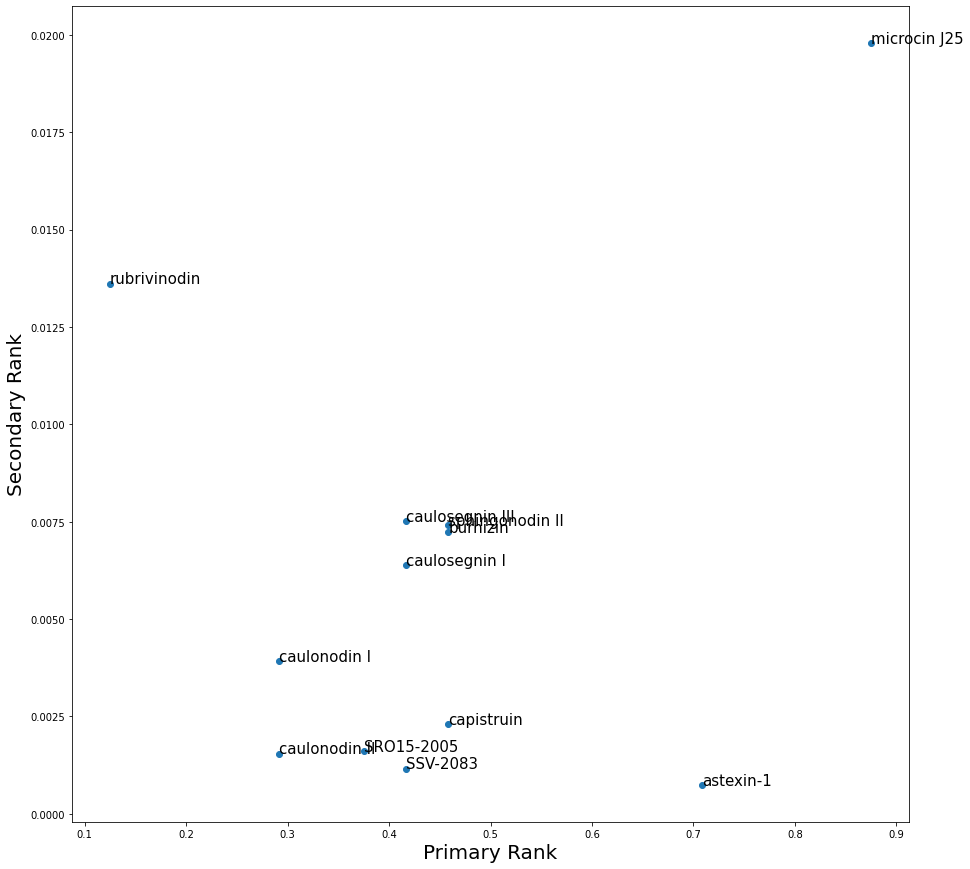

In [127]:
import matplotlib.pyplot as plt
import numpy as np
secondaryRank = []
primaryRank = []
names = []

for real_lasso in real_lassos:
    if not "secondaryRank" in real_lasso:
        continue
    secondaryRank.append(real_lasso["secondaryRank"])
    primaryRank.append(real_lasso["primaryRank"])
    names.append(real_lasso["name"])

fig, ax = plt.subplots()
ax.scatter(primaryRank, secondaryRank)
ax.set_xlabel('Primary Rank', fontsize=20)
ax.set_ylabel('Secondary Rank', fontsize=20)

fig.set_figheight(15)
fig.set_figwidth(15)

for i, txt in enumerate(names):
    ax.annotate(txt, (primaryRank[i], secondaryRank[i]), fontsize=15)

In [128]:
noiseSecondaryRank = [match["secondaryRank"] for match in matches]

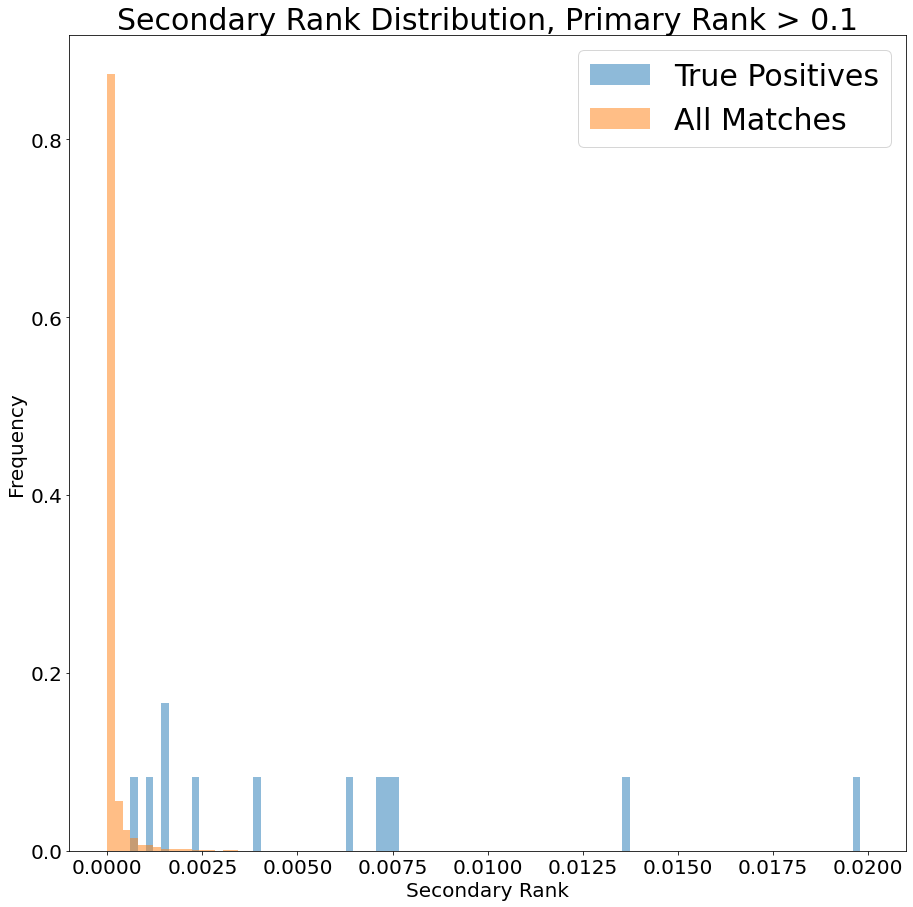

In [153]:
fig, ax = plt.subplots()

bins = np.linspace(0, 0.02, 100)

ax.hist(secondaryRank, bins, alpha=0.5, label='True Positives', weights=np.zeros_like(secondaryRank) + 1. / len(secondaryRank))
ax.hist(noiseSecondaryRank, bins, alpha=0.5, label='All Matches', weights=np.zeros_like(noiseSecondaryRank) + 1. / len(noiseSecondaryRank))
ax.legend(loc='upper right', fontsize=30)
ax.set_xlabel('Secondary Rank', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)
ax.set_title("Secondary Rank Distribution, Primary Rank > 0.1", fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=20)

fig.set_figheight(15)
fig.set_figwidth(15)

In [166]:
secondaryRank = []
noiseSecondaryRank = []
cutoff = 0.5
for match in matches:
    if(match["rank"] > cutoff):
        noiseSecondaryRank.append(match["secondaryRank"])
for real_lasso in real_lassos:
    if not "secondaryRank" in real_lasso:
        continue
    if(real_lasso["primaryRank"] > cutoff):
        secondaryRank.append(real_lasso["secondaryRank"])

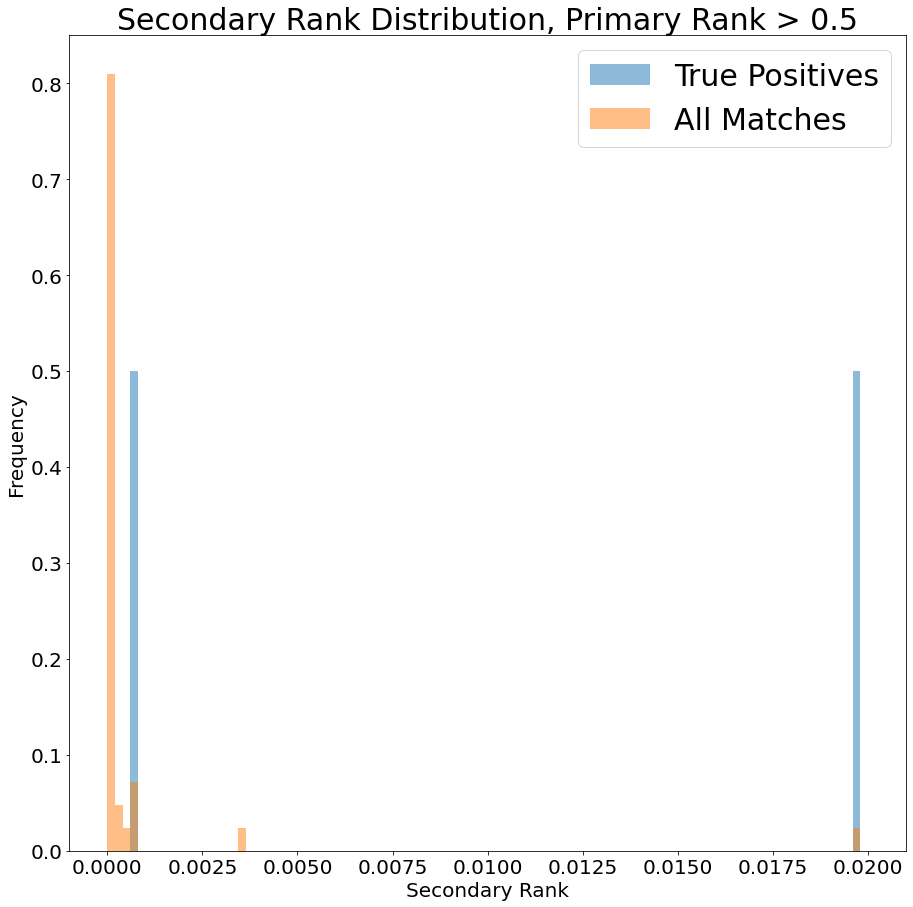

In [168]:
fig, ax = plt.subplots()

bins = np.linspace(0, 0.02, 100)

ax.hist(secondaryRank, bins, alpha=0.5, label='True Positives', weights=np.zeros_like(secondaryRank) + 1. / len(secondaryRank))
ax.hist(noiseSecondaryRank, bins, alpha=0.5, label='All Matches', weights=np.zeros_like(noiseSecondaryRank) + 1. / len(noiseSecondaryRank))
ax.legend(loc='upper right', fontsize=30)
ax.set_xlabel('Secondary Rank', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)
ax.set_title(f"Secondary Rank Distribution, Primary Rank > {cutoff}", fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=20)

fig.set_figheight(15)
fig.set_figwidth(15)

In [204]:
secondaryRank = []
noiseSecondaryRank = []
primaryCutoff = 0.25
for match in matches:
    if(match["rank"] > primaryCutoff):
        found_lasso = False
        for real_lasso in real_lassos:
            if (match["sequence"][-10:] == real_lasso["sequence"][-10:]):
                found_lasso = True
        if not found_lasso:
            noiseSecondaryRank.append(match["secondaryRank"])
for real_lasso in real_lassos:
    if not "secondaryRank" in real_lasso:
        continue
    if(real_lasso["primaryRank"] > primaryCutoff):
        secondaryRank.append(real_lasso["secondaryRank"])

In [205]:
positive_scores = secondaryRank
negative_scores = noiseSecondaryRank
fpr = []
tpr = []
true_positives = len(positive_scores)
true_negatives = len(negative_scores)
switched = False
for cutoff in np.linspace(0,0.01,500):
    tpval = np.sum(positive_scores >= cutoff) / true_positives
    fpval = 1 - (np.sum(negative_scores < cutoff) / true_negatives)
    tpr.append(tpval)
    fpr.append(fpval)
    if(not switched):
        print(f'{cutoff}: {tpval} - {fpval}')
    if(tpval < 1 and not switched):
        switched = True

0.0: 1.0 - 1.0
2.0040080160320643e-05: 1.0 - 0.310930576070901
4.0080160320641287e-05: 1.0 - 0.2093796159527327
6.0120240480961926e-05: 1.0 - 0.16285081240768096
8.016032064128257e-05: 1.0 - 0.12961595273264404
0.00010020040080160322: 1.0 - 0.10672082717872966
0.00012024048096192385: 1.0 - 0.0901033973412112
0.0001402805611222445: 1.0 - 0.08161004431314622
0.00016032064128256515: 1.0 - 0.07237813884785815
0.00018036072144288578: 1.0 - 0.06610044313146235
0.00020040080160320644: 1.0 - 0.05871491875923196
0.00022044088176352707: 1.0 - 0.05465288035450522
0.0002404809619238477: 1.0 - 0.052067946824224554
0.00026052104208416834: 1.0 - 0.0483751846381093
0.000280561122244489: 1.0 - 0.04579025110782864
0.00030060120240480966: 1.0 - 0.04431314623338256
0.0003206412825651303: 1.0 - 0.03877400295420974
0.0003406813627254509: 1.0 - 0.03545051698670609
0.00036072144288577156: 1.0 - 0.03323485967503692
0.00038076152304609225: 1.0 - 0.030280649926144765
0.0004008016032064129: 1.0 - 0.02880354505169

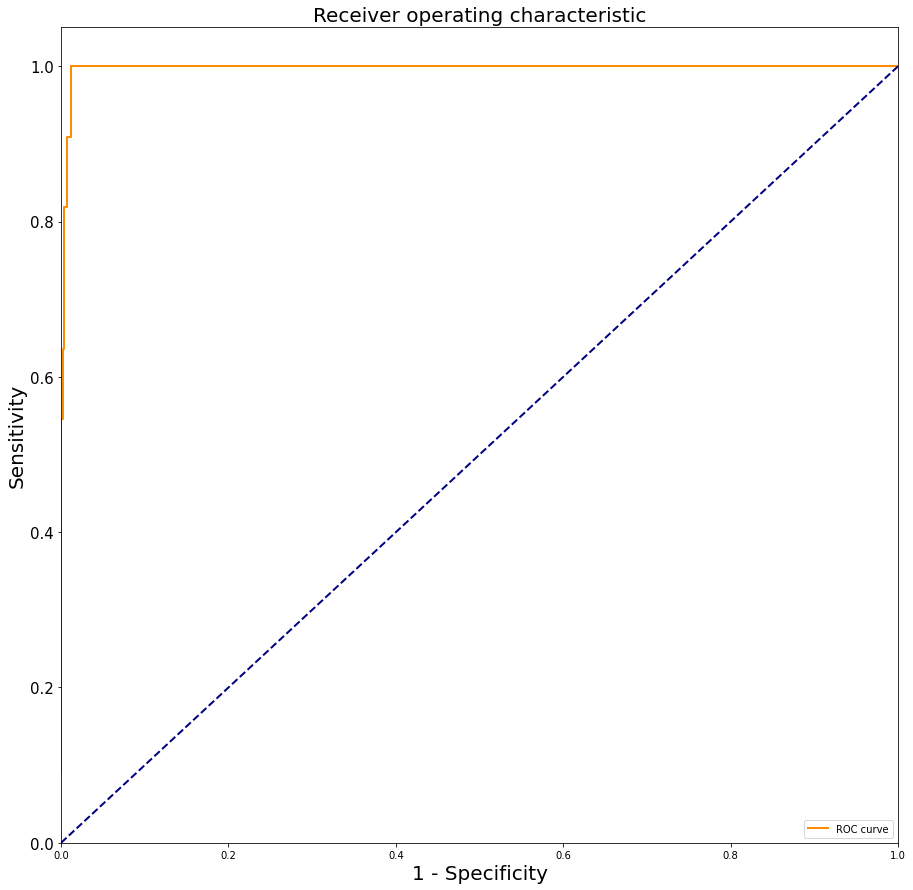

In [206]:
plt.figure(figsize=(15, 15))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity', fontsize=20)
plt.ylabel('Sensitivity', fontsize=20)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right")
plt.yticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [209]:
print(len(noiseSecondaryRank) * 0.012555391432791718)
print(len(secondaryRank))

33.99999999999997
11
